In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import codecs

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
data = pd.read_csv("data/clean_data.csv")
data.tail()

,text,choose_one,class_label
10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1
10855,evacuation order lifted for town of roosevelt,Relevant,1
10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1
10857,to conference attendees! the blue line from th...,Relevant,1
10858,the death toll in a is suicide car bombing on...,Relevant,1


In [3]:
data.groupby("choose_one").count()

,text,class_label
choose_one,,
Can't Decide,16,16
Not Relevant,6186,6186
Relevant,4657,4657


### Tokenization

In [4]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["text"].apply(tokenizer.tokenize)
data.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


### Bag of Words Counts

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
def plot_LSA(data, labels):
    
    lsa = TruncatedSVD(n_components=2) # truncate data matrix to top k rank
    lsa.fit(data)
    lsa_scores = lsa.transform(data)
    color_mapper = {label:idx for idx,label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['red','blue','blue']
        
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, 
                c=labels, cmap=matplotlib.colors.ListedColormap(colors)
                )
    red_patch = mpatches.Patch(color='red', label='Irrelevant')
    green_patch = mpatches.Patch(color='blue', label='Disaster')
    plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

In [7]:
list_corpus = data["text"].tolist()
list_labels = data["class_label"].tolist()

### Count vectorization

In [8]:
count_vectorizer = CountVectorizer()
data_counts = count_vectorizer.fit_transform(list_corpus)

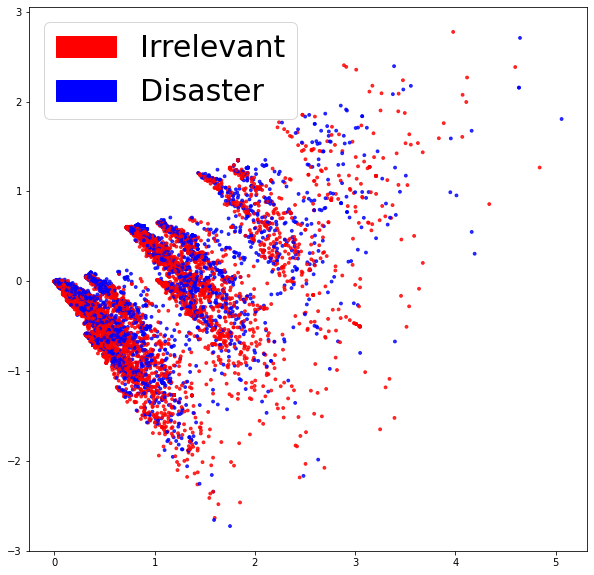

In [9]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(data_counts, list_labels)
plt.show()

### TF-IDF

In [10]:
tfidf_vectorizer = TfidfVectorizer()
data_tfidf = tfidf_vectorizer.fit_transform(list_corpus)

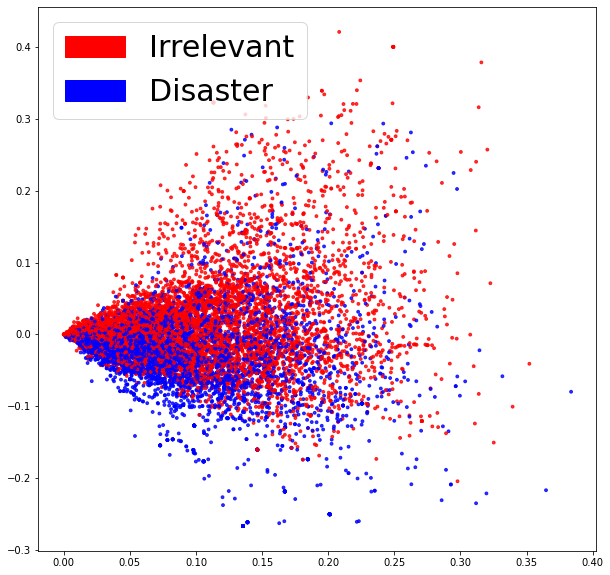

In [11]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(data_tfidf, list_labels)
plt.show()

### Standford Word2Vec

You can download the GloVe vectors from [the Glove page](https://nlp.stanford.edu/projects/glove/). or from [this zip file](https://nlp.stanford.edu/data/glove.6B.zip)

In [12]:
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [13]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    
    if len(tokens_list)<1:
        return np.zeros(k)
    
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    
    return averaged


def get_word2vec_embeddings(vectors, data, generate_missing=False):
    embeddings = data['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [14]:
# adjust the path relative to your glove file
glove_file = datapath('glove.6B/glove.6B.50d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")

glove2word2vec(glove_file, word2vec_glove_file)
word2vec = KeyedVectors.load_word2vec_format(word2vec_glove_file)

<ipython-input-14-8636ff16e77c>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


In [15]:
data.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [16]:
embeddings = get_word2vec_embeddings(word2vec, data)

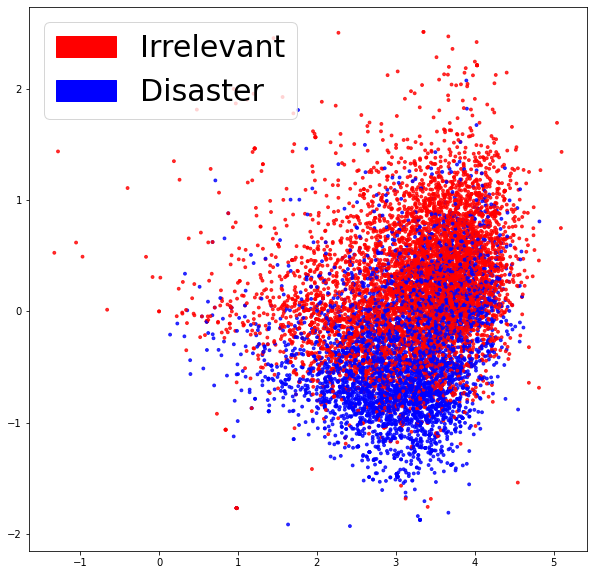

In [17]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

### Gensim visualization

In [18]:
def analogy(x1, x2, y1):
    result = word2vec.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]


def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            #words = np.random.choice(list(model.vocab.keys()), sample)
            words = np.random.choice(list(model.wv.index_to_key), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [19]:
print ("# of words", len(word2vec.key_to_index))

# of words 400000


In [20]:
word2vec.most_similar('banana')

[('coconut', 0.7097253799438477),
 ('mango', 0.705482542514801),
 ('bananas', 0.6887733936309814),
 ('potato', 0.6629636287689209),
 ('pineapple', 0.6534532308578491),
 ('fruit', 0.6519855260848999),
 ('peanut', 0.6420576572418213),
 ('pecan', 0.6349173188209534),
 ('cashew', 0.6294420957565308),
 ('papaya', 0.6246591210365295)]

In [21]:
word2vec.most_similar(negative='banana')

[('keyrates', 0.7173938751220703),
 ('sungrebe', 0.7119238972663879),
 ('þórður', 0.7067720293998718),
 ('zety', 0.7056615948677063),
 ('23aou94', 0.6959497928619385),
 ('___________________________________________________________',
  0.694915235042572),
 ('elymians', 0.6945434212684631),
 ('camarina', 0.6927202343940735),
 ('ryryryryryry', 0.6905654072761536),
 ('maurilio', 0.6865653395652771)]

In [22]:
analogy('ghana', 'ghanian', 'senegal')

'senegalese'

In [23]:
analogy('good', 'fantastic', 'bad')

'terrible'

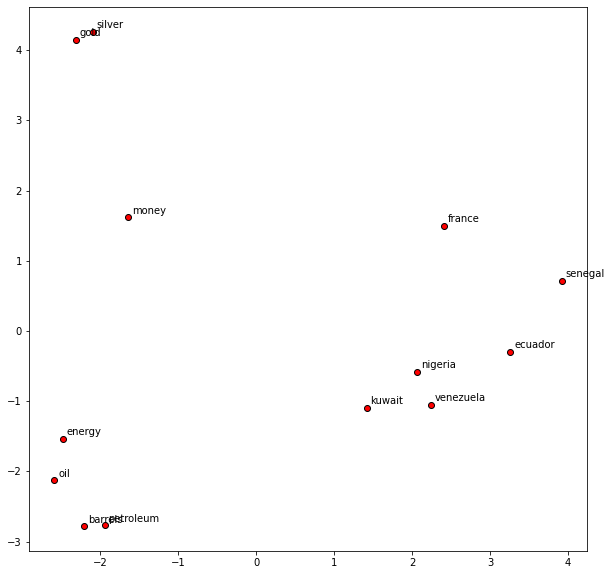

In [24]:
words = ['barrels', 'silver', 'ecuador', 'energy', 'kuwait', 'money', 'oil', 'gold', 'petroleum', \
         'venezuela', 'nigeria', 'senegal', 'france']
display_pca_scatterplot(word2vec, words)

In [25]:
# calculate: woman + (king - man) = ?
result = word2vec.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
print(result)

[('queen', 0.7698541283607483), ('monarch', 0.6843380928039551), ('throne', 0.6755736470222473), ('daughter', 0.6594556570053101), ('princess', 0.6520534157752991), ('prince', 0.6517035365104675), ('elizabeth', 0.6464517712593079), ('mother', 0.6311717629432678), ('emperor', 0.6106470823287964), ('wife', 0.6098655462265015)]


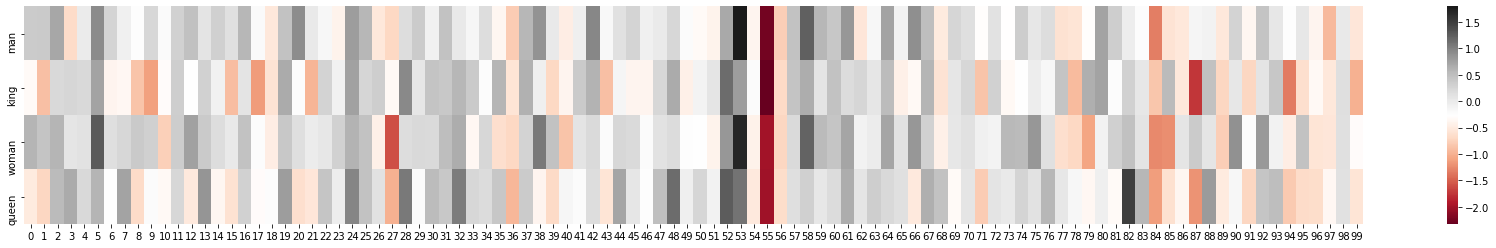

In [26]:
plt.figure(figsize=(30,4))
df = pd.DataFrame({'man': word2vec['man'],
                   'king': word2vec['king'],
                   'woman': word2vec['woman'],
                   'queen': word2vec['queen']
                  })
sns.heatmap(df.T, fmt="g", cmap='RdGy')
plt.show()

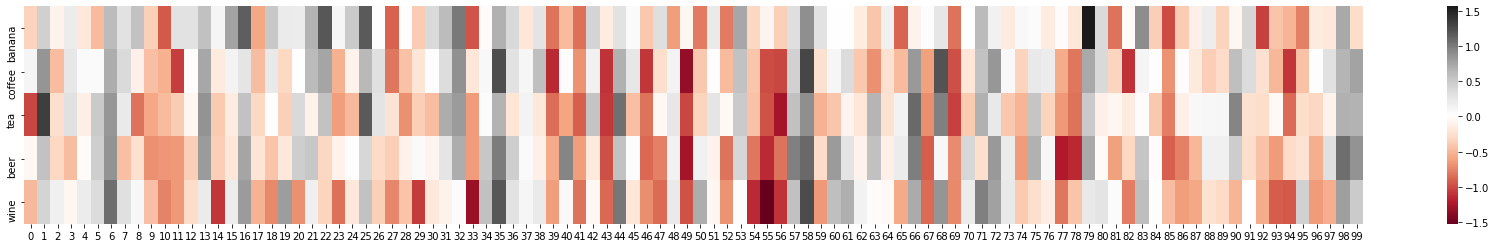

In [27]:
plt.figure(figsize=(30,4))
df = pd.DataFrame({'banana': word2vec['banana'],
                   'coffee': word2vec['coffee'],
                   'tea': word2vec['tea'],
                   'beer': word2vec['beer'],
                   'wine': word2vec['wine'],
                  })
sns.heatmap(df.T, fmt="g", cmap='RdGy')
plt.show()

why do we have a fairly high similarity between logitec and cat, or steel and cloths, or ipod and banana? while there is a very low similarity between ipod and steel and logitech and cloth

In [28]:
print('logitech', '/', 'cat', '->', word2vec.similarity('logitech', 'cat'))
print('steel', '/', 'cloth', '->', word2vec.similarity('steel', 'cloth'))
print('ipod', '/', 'banana', '->', word2vec.similarity('ipod', 'banana'))

logitech / cat -> 0.26268926
steel / cloth -> 0.42388725
ipod / banana -> 0.2435296


In [29]:
print ('ipod', '/', 'steel', '->', word2vec.similarity('ipod', 'steel'))
print ('logitech', '/', 'cloth', '->', word2vec.similarity('logitech', 'cloth'))

ipod / steel -> 0.054595962
logitech / cloth -> -0.0063639972


In [ ]:
# !python -m spacy download en_core_web_sm

## 

### Training a word2vec

In [30]:
# Install gensim - pip install gensim
import nltk
import urllib
import bs4 as bs
import re

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd
import numpy as np

import spacy
sp = spacy.load('en_core_web_sm')

In [31]:
# link to the wikipedia of the president Senegal
raw_html = urllib.request.urlopen('https://en.wikipedia.org/wiki/Macky_Sall')  
raw_html = raw_html.read()
bs_html = bs.BeautifulSoup(raw_html,'lxml')

# Fetching the data
text = ""
for paragraph in bs_html.find_all('p'):
    text += paragraph.text

### Preprocess data

In [32]:
def lemmatizer(sentence):
    spacy_sentence = sp(sentence)
    tokens = []
    for word in spacy_sentence:
        tokens.append(word.lemma_)
        
    return tokens

In [33]:
# print first 200 characters
text[:200]

'\nMacky Sall (born 11 December 1961[1]) is a Senegalese politician who has been President of Senegal since April 2012. He was re-elected President in the first round voting in February 2019 Senegalese '

In [34]:
# Preprocessing the data
text = re.sub(r'\[[0-9]*\]',' ',text) # replace all consecutive figures within square brackets
text = re.sub(r'\s+',' ',text) # remove two or more whitespaces with a single whitespace
text = text.lower() # convert all text to loser cases

text = re.sub(r'\d',' ',text) # replace single digits with space
text = re.sub(r'\s+',' ',text) 

In [35]:
# print first 200 characters
text[:200]

' macky sall (born december ) is a senegalese politician who has been president of senegal since april . he was re-elected president in the first round voting in february senegalese presidential electi'

In [36]:
# check first few sentences
sentences = nltk.sent_tokenize(text)
sentences = [lemmatizer(sentence.strip()) for sentence in sentences]

In [37]:
# Training the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
print ("# of words", len(model.wv.key_to_index))

# of words 731


In [38]:
sims = model.wv.most_similar('french', topn=5)  # get other similar words
print(sims)

[('dakar', 0.3295056223869324), ('senegal', 0.31672269105911255), ('local', 0.3140730857849121), ('of', 0.30600348114967346), ('ps', 0.30371156334877014)]


In [39]:
vector = model.wv['french']

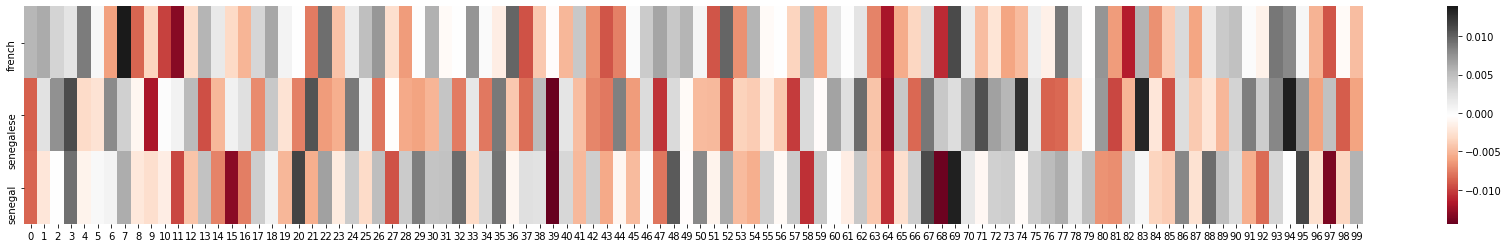

In [40]:
vector = model.wv['senegalese']  # get numpy vector of a word
plt.figure(figsize=(30,4))
df = pd.DataFrame({'french': model.wv['french'],
                   'senegalese': model.wv['senegalese'],
                   'senegal': model.wv['senegal']
                  })
sns.heatmap(df.T, fmt="g", cmap='RdGy')
plt.show()